<a href="https://colab.research.google.com/github/kimhalyn/RNN-LSTM/blob/main/%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 파일 불러오기
price = pd.read_excel('/content/drive/MyDrive/삼성주가.xlsx', sheet_name='samsung')
price.head()

,일자,시가,고가,저가,종가,거래량
0,20200107,55700,56400,55600,55800,9893846
1,20200106,54900,55600,54600,55500,10278951
2,20200103,56000,56600,54900,55500,15422255
3,20200102,55500,56000,55000,55200,12993228
4,20191230,56200,56600,55700,55800,8356767


In [ ]:
# 날짜 포맷으로 변환
price['일자'] = pd.to_datetime(price['일자'], format='%Y%m%d')
price.head()

,일자,시가,고가,저가,종가,거래량
0,2020-01-07,55700,56400,55600,55800,9893846
1,2020-01-06,54900,55600,54600,55500,10278951
2,2020-01-03,56000,56600,54900,55500,15422255
3,2020-01-02,55500,56000,55000,55200,12993228
4,2019-12-30,56200,56600,55700,55800,8356767


Text(0, 0.5, 'price')

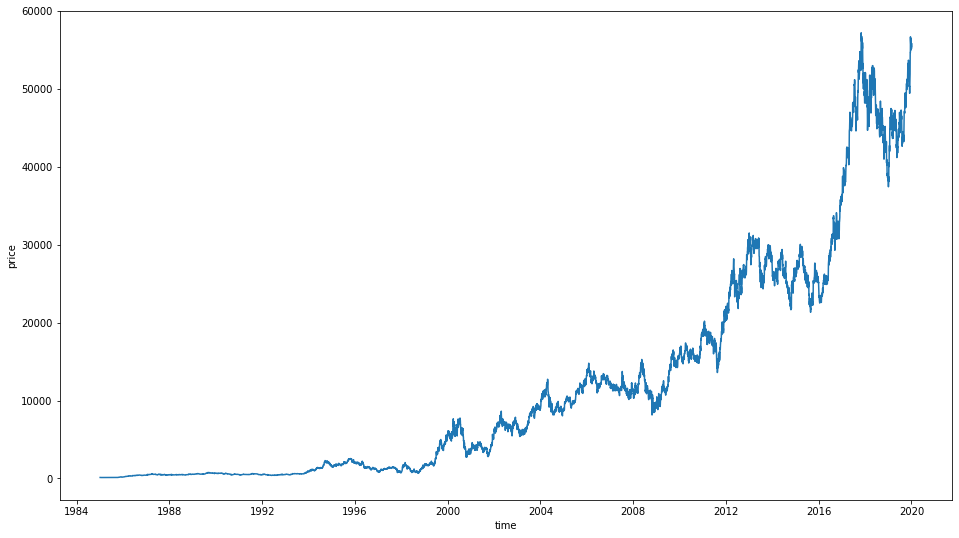

In [ ]:
# 주식 시각화
plt.figure(figsize=(16, 9))
sns.lineplot(y=price['종가'], x=price['일자'])
plt.xlabel('time')
plt.ylabel('price')

In [ ]:
# 정규화(MinMaxScaler를 활용하여 전체 데이터 0~1값을 갖도록 해줌)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 스케일 적용할 columns 정의
scale_cols = ['시가', '고가', '저가', '종가', '거래량']

# 스케일 후 columns
scaled = scaler.fit_transform(price[scale_cols])
scaled

array([[9.68632371e-01, 9.80489165e-01, 9.79521582e-01, 9.75133091e-01,
        3.02914256e-02],
       [9.54691203e-01, 9.66552853e-01, 9.61867773e-01, 9.69879518e-01,
        3.14704796e-02],
       [9.73860309e-01, 9.83973242e-01, 9.67163916e-01, 9.69879518e-01,
        4.72174410e-02],
       ...,
       [2.26543984e-04, 2.43885444e-04, 2.29499515e-04, 2.27654805e-04,
        2.36326702e-03],
       [2.26543984e-04, 2.26465055e-04, 2.29499515e-04, 2.10142897e-04,
        3.32176032e-04],
       [2.43970445e-04, 2.43885444e-04, 2.47153323e-04, 2.27654805e-04,
        3.42181482e-04]])

In [ ]:
# 스케일이 완료된 columns로 새로운 데이터프레임 생성
df = pd.DataFrame(scaled, columns=scale_cols)

In [ ]:
# train, test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), 
                                                    df['종가'], 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=False)

In [ ]:
x_train.shape, y_train.shape

((7430, 4), (7430,))

In [ ]:
x_test.shape, y_test.shape

((1858, 4), (1858,))

In [ ]:
# 데이터셋 구성
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# 하이퍼파라미터 정의
# window_size: 얼마동안의 데이터에 기반하여 다음날 값을 예측할 것인지 정하는 파라미터
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 데이터셋 구성확인
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [ ]:
# LSTM 모델 1
tf.model = tf.keras.Sequential(); 
tf.model.add(tf.keras.layers.LSTM(16, activation='tanh', input_shape=[WINDOW_SIZE, 1])) 
tf.model.add(tf.keras.layers.Dense(16, activation="relu")) 
tf.model.add(tf.keras.layers.Dense(1)) 
tf.model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# LSTM 모델 생성 2
model = Sequential()
model.add(LSTM(16, input_shape=[WINDOW_SIZE, 1], activation='tanh'))
model.add(Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 학습
model.compile(loss=Huber(), optimizer=Adam(0.0005), metrics=['mse'])

In [ ]:
## earlystopping은 10번 epoch동안 val_loss 개선이 없다면 학습을 멈춤
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

## val_loss 기준 체크포인터 생성.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
##
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
232/232 [==============================] - 6s 18ms/step - loss: 0.0139 - mse: 0.0278 - val_loss: 9.5839e-05 - val_mse: 1.9168e-04

Epoch 00001: val_loss improved from inf to 0.00010, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
232/232 [==============================] - 3s 14ms/step - loss: 7.0923e-04 - mse: 0.0014 - val_loss: 1.8588e-05 - val_mse: 3.7176e-05

Epoch 00002: val_loss improved from 0.00010 to 0.00002, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
232/232 [==============================] - 3s 14ms/step - loss: 1.4128e-04 - mse: 2.8255e-04 - val_loss: 9.5892e-06 - val_mse: 1.9178e-05

Epoch 00003: val_loss improved from 0.00002 to 0.00001, saving model to tmp/ckeckpointer.ckpt
Epoch 4/50
232/232 [==============================] - 3s 14ms/step - loss: 1.1422e-04 - mse: 2.2845e-04 - val_loss: 6.8467e-06 - val_mse: 1.3693e-05

Epoch 00004: val_loss improved from 0.00001 to 0.00001, saving model to tmp/ckeckpointer.ckpt
Epoch 5/50
232/232 [====================

In [ ]:
# 체크포인터 로드
model.load_weights(filename)

In [ ]:
# 학습모델로 주가 예측
pred = model.predict(test_data)

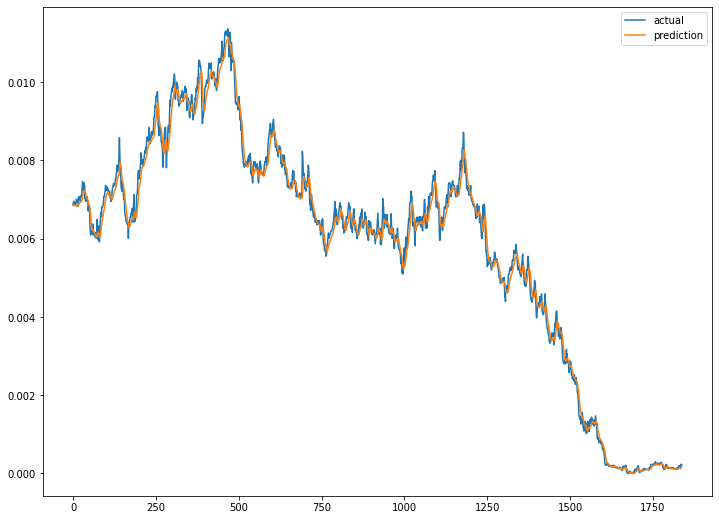

In [ ]:
# 실제 및 예측 데이터 시각화
# y_test 데이터에 [20:]슬라이싱 이유: 20일치의 데이터로 21일치를 예측해야 하므로
# test_data로 예측할 때, 앞의 20일은 예측하지 않음
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()